In [55]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from collections import Iterable
import six

XS area [  9.19762417e+13   1.20522972e+14   1.46003183e+14   1.69421686e+14
   1.91318292e+14   2.12025301e+14   2.31765606e+14   2.50697884e+14
   2.68940162e+14] m^2
SA <function SA at 0x7f36901a6f28> m^2
XS area 146003182814565.62 m^2
SA <function SA at 0x7f36901a6f28> m^2
XS area 146003182814565.62 m^2
SA <function SA at 0x7f36901a6f28> m^2


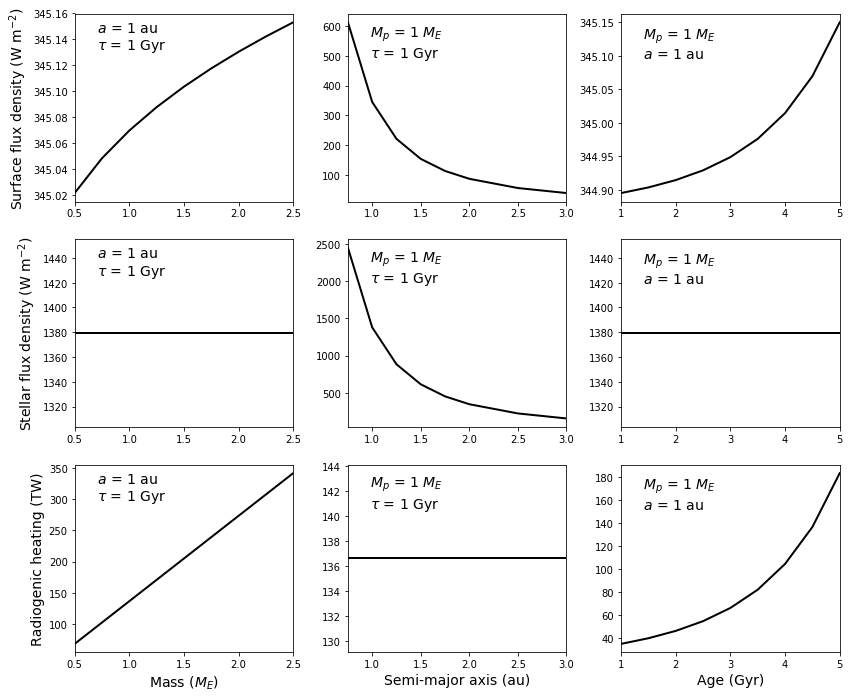

In [179]:
""" 0-D steady state model, homogenous interior """

M_E = 5.972e24 # earth mass in kg
L_sun =  3.9e26 # solar luminosity in W
years2sec = 31557600
AU2m = 1.5e11

# Half-lives in years from Dye (2012) in Treatise on Geophys
t_40K_half = 1.26e9 
t_235U_half = 7.04e8 
t_238U_half = 4.46e9
t_232Th_half = 1.4e10

# Heating rates of radioisotopes per mass of isotope at tau=0 in W kg^-1 from Dye (2012) in Treatise on Geophys
h_40K_0 = 28.47e-6
h_235U_0 = 568.47e-6
h_238U_0 = 95.13e-6
h_232Th_0 = 26.3e-6

# radioisotope abundances
X_K = 250 # initial abundance of K in wt ppm (in Treatise on Geophysics, think these are by weight but double check)
X_U = 2e-2# initial abundane of U in wt ppm ""
X_Th = 7e-2 # initial abundance of Th in wt ppm ""
# TODO: are the below values in moles or mass? 
K_0 = 0.0117e-2 # ratio of 40-K to total K at time 0 (in Treatise on Geophysics)
U_0_235 = 0.0072 # ratio of 235-U to total U at time 0 (in Treatise on Geophysics)
U_0_238 = 0.9927 # ratio of 238-U to total U at time 0 (in Treatise on Geophysics)
Th_0 = 1 # ratio of 232-Th to total Th at time 0 (in Treatise on Geophysics)
H_0 = [h_40K_0, h_235U_0, h_238U_0, h_232Th_0]
X_0 = [X_K, X_U, X_U, X_Th]
el_0 = [K_0, U_0_235, U_0_238, Th_0]
t_half = [t_40K_half, t_235U_half, t_238U_half, t_232Th_half]

L=1 # stellar luminosity in solar units
Alb=0
rho_m=4500

paramargs = dict(Alb=Alb, rho_m=rho_m, H_0=np.array(H_0), X_0=np.array(X_0)*1e-6, el_0=np.array(el_0), 
                 t_half=np.array(t_half)*years2sec, L=L*L_sun)

def SA(M, rho):
    V = vol(M, rho)
    R = radius(V)
    return 4*np.pi*R**2

def radius(V):
    return (3*V/(4*np.pi))**(1/3)

def vol(M, rho):
    return M/rho

def Q_star(L, Alb, a, **kwargs):
    """Calculate incident stellar flux density (over entire heliocentric sphere with radius a) in W m^-2"""
    return L*(1-Alb)/(4*np.pi*a**2) # 4pi is the total solid angle subtended by a sphere

def h_rad(tau, H_0, X_0, el_0, t_half, **kwargs):
    """Calculate radiogenic heating in W kg^-1"""
    if not isinstance(tau, Iterable):
        h = sum(H_0*X_0*el_0*np.exp(np.log(2)*tau/t_half))
    else:
        # for a list of ages
        h = np.zeros(len(tau))
        for ii, val in enumerate(tau):
            h[ii] = sum(H_0*X_0*el_0*np.exp(np.log(2)*val/t_half))
    return h

def q_out_ss(L, Alb, a, rho_m, M_p, tau, H_0, X_0, el_0, t_half, **kwargs):
    """Calculate steady-state surface flux density in W m^-2
    
    @ eq, Q_sfc = Q_star + Q_cond, where Q_cond = Q_rad (total heat loss from top of mantle is equal to total radiogenic heating)
    """
    R_p = radius(vol(M_p, rho_m))
    print('XS area', np.pi*R_p**2, 'm^2')
    Q_down = Q_star(L, Alb, a,)*(np.pi*R_p**2) # in W
    #print('Q_star', Q_down, 'W')
    q_up = h_rad(tau, H_0, X_0, el_0, t_half) # in W kg^-1
    #print('h_rad', q_up, 'W kg^-1')
    Q_up = q_up*M_p # in W
    #print('H_rad', Q_up, 'W')
    Q_bb = Q_down + Q_up # in W
    #print('Q_bb out = Q_* + Q_cond = ',Q_bb,'W')
    #print('SA', SA(M_p, rho_m), 'm^2')
    q_bb = Q_bb/SA(M_p, rho_m) # divide by total emitting area to get flux density
    return q_bb

def plot_one(ax, x, y, xlabel, ylabel, labelsize, lw=1, c='k', text=None, **kwargs):
    ax.set_xlabel(xlabel, fontsize=labelsize)
    ax.set_ylabel(ylabel, fontsize=labelsize)
    ax.plot(x, y, c=c, lw=lw)
    ax.set_xlim(x.min(), x.max())
    if text is not None:
        ax.text(0.1, 0.95, text, ha='left',va='top', transform=ax.transAxes, fontsize=labelsize)
    return ax

def plt_flux_multi(n_cols, *args, **kwargs):
    fig, axes = plt.subplots(3, n_cols, figsize=(4*n_cols, 10))
    ii = 0
    while ii < n_cols: # for each x variable column (make 3 rows)
        
        kwargs_i = kwargs.copy()
        for name, value in kwargs_i.items():
            if (isinstance(value, Iterable) and not isinstance(value, six.string_types) 
                    and not (name=='H_0' or name=='el_0' or name=='X_0' or name=='t_half'
                            or name=='ylabels')):
                # i.e. for each subplot col if different
                kwargs_i[name] = value[ii]
        xs = list(kwargs_i.values())[ii]
        xnorm = kwargs_i['xnorm']
        kwargs_i['ylabel']=''
        
        # rad heating
        ax = axes[2][ii]
        H_rad = h_rad(**kwargs_i)*M_p[ii]
        if ii==0:
            # only label leftmost col
            kwargs_i['ylabel']=kwargs_i['ylabels'][2]
        try:
            ax = plot_one(ax, xs*xnorm, H_rad*1e-12, **kwargs_i)
        except ValueError:
            # if scalar
            ax = plot_one(ax, xs*xnorm, [H_rad*1e-12]*len(xs), **kwargs_i)
          
        # insolation flux density
        ax = axes[1][ii]
        kwargs_i['xlabel']=''
        q_s = Q_star(**kwargs_i)
        if ii==0:
            # only label leftmost col
            kwargs_i['ylabel']=kwargs_i['ylabels'][1]
        try:
            ax = plot_one(ax, xs*xnorm, q_s, **kwargs_i)
        except ValueError:
            # if scalar
            ax = plot_one(ax, xs*xnorm, [q_s]*len(xs), **kwargs_i)
        
        # flux out of surface (bb)
        ax = axes[0][ii]
        kwargs_i['xlabel']=''
        if ii==0:
            # only label leftmost col
            kwargs_i['ylabel']=kwargs_i['ylabels'][0]
        q_out = q_out_ss(**kwargs_i)
        ax = plot_one(ax, xs*xnorm, q_out, **kwargs_i)
        
        ii += 1
        
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.25, hspace=0.2)
    return fig, axes     


M_p_0 = 1 # M_E
a_0 = 1 # AU
age_0 = 4.5 # Gyr

M_p_vec = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5] # M_E
a_vec = [0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3] # AU
age_vec = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5] # Gyr

M_p = [np.array(M_p_vec)*M_E, M_p_0*M_E, M_p_0*M_E] # kg
a = [a_0*AU2m, np.array(a_vec)*AU2m, a_0*AU2m] # m
tau = [age_0*1e9*years2sec, age_0*1e9*years2sec, np.array(age_vec)*1e9*years2sec] # s
varargs = dict(M_p=M_p, a=a, tau=tau)

xlabel=['Mass ($M_E$)', 'Semi-major axis (au)', 'Age (Gyr)']
texty=['$a$ = 1 au\n'+r'$\tau$'+' = 1 Gyr',
      '$M_p$ = 1 $M_E$\n'+r'$\tau$'+' = 1 Gyr',
      '$M_p$ = 1 $M_E$\n$a$ = 1 au']
rowcolour=['k']*3 # one colour per row
ylabels=['Surface flux density (W m$^{-2}$)', 
         'Stellar flux density (W m$^{-2}$)',
         'Radiogenic heating (TW)',]
xnorm=[M_E**-1, AU2m**-1, years2sec**-1*1e-9]
pltargs=dict(labelsize=14, lw=2, ylabels=ylabels, xlabel=xlabel, c=rowcolour, xnorm=xnorm, text=texty)

fig, _ = plt_flux_multi(n_cols=len(varargs), **varargs, **paramargs, **pltargs)
fig.savefig('figs/ss_fluxes.pdf', bbox_inches='tight')

# TODO: parameterize as ratios to Earth values
 